```python
def two_site(partial_pressures, K1, K2, k4, K5, k0, T):
    pA, pB, pC = partial_pressures

    k3 = k0 * np.exp(-37000 / (8.314 * T))
    S = (k3 / k4) * K1 * K2 * pA * pB

    # theta_prime and theta_star
    num = 50
    theta_prime = 0.05
    theta_star = 0.05
    
    for _ in range(num):
        theta_star_new = 1 / (1 + K2 * pB + np.sqrt(S * theta_prime / theta_star))
        theta_prime_new = 1 / (1 + K1 * pA + pC / K5 + np.sqrt(S * theta_star / theta_prime))
        theta_star = np.maximum(0, np.minimum(1, theta_star_new))  
        theta_prime = np.maximum(0, np.minimum(1, theta_prime_new))
        
#     print("theta_star:", theta_star)
#     print("theta_prime:", theta_prime)  


    rate = k3 * K1 * K2 * pB * pA * theta_star * theta_prime
    return rate




# Step 3: Objective Function
def objective(params):
    K1, K2, k4, K5, k0 = params
    model_rates = two_site(partial_pressures.T, K1, K2, k4, K5, k0, Temp)
    return np.abs((model_rates - experimental_rates)/experimental_rates) * 100


# Step 4: least_squares optimization

initial_params = [4.6, 100000, 50, 10, 100]  # K1, K2, k3(not included - should be small), k4(fast step), K5, k0
lb = [0, 1, 0, 0, 0]                 # K1, K2, k4, K5, k0
ub = [np.inf, np.inf, np.inf, np.inf, np.inf]
bounds1 = (lb,ub)

result = least_squares(objective, initial_params, bounds=bounds1)
K1n_fit, K2n_fit, k4n_fit, K5n_fit, k0n_fit = result.x

model_rates2 = two_site(partial_pressures.T, K1n_fit, K2n_fit, k4n_fit, K5n_fit, k0n_fit, Temp)
percentage_error2 = np.abs((model_rates2 - experimental_rates) / experimental_rates) * 100


print("\n Model rates 2",model_rates2)
print("\n")
print(K1n_fit)
print(K2n_fit)
print(k4n_fit)
print(K5n_fit)
print("k0: ", k0n_fit)
print("\n")

print("\nPercentage error least squares are :",percentage_error2)
```
https://stackoverflow.com/questions/76603587/non-linear-data-fitting-for-kinetic-data

```
solve {x = 1/(1+A+sqrt(s*y/x)), y = 1/(1+A+B +sqrt(s*x/y))} for x and y
```

https://www.wolframalpha.com/input?i=solve+%7Bx+%3D+1%2F%281%2BA%2Bsqrt%28s*y%2Fx%29%29%2C+y+%3D+1%2F%281%2BA%2BB+%2Bsqrt%28s*x%2Fy%29%29%7D+for+x+and+y

```
jacobian {1/(1+B+sqrt(s*y/x)), 1/(1+A+C +sqrt(s*x/y))} wrt x and y
```

https://www.wolframalpha.com/input?i=jacobian+%7B1%2F%281%2BB%2Bsqrt%28s*y%2Fx%29%29%2C+1%2F%281%2BA%2BC+%2Bsqrt%28s*x%2Fy%29%29%7D+wrt+x+and+y

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize 
import logging

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
class Kinetic:
    
    """Langmuir-Hinshelwood Two-Site Kinetic Model Solver"""
    
    R = 8.314              # J/mol.K
    Ea = 37000             # J/mol
    T = 473.15             # K
    theta_ = [0.9, 0.9]    # 1
    
    @staticmethod
    def k3(p, k1, k2, k4, k5, k0):
        """Arrhenius estimation for k3"""
        return k0*np.exp(-Kinetic.Ea/(Kinetic.R*Kinetic.T))

    @staticmethod
    def s(p, k1, k2, k4, k5, k0):
        """Partial kinetic rate"""
        pA, pB, pC = p
        k3 = Kinetic.k3(p, k1, k2, k4, k5, k0)
        return (k1*k2*k3/k4)*pA*pB
    
    @staticmethod
    def equation(x, y, C, s):
        return 1/(1 + C + np.sqrt(s*y/x)) - x
    
    @staticmethod
    def isopleth(x, y, s):
        return (x + np.sqrt(s*x*y) - 1)/x
    
    @staticmethod
    def system(theta, p, k1, k2, k4, k5, k0):
        """Isothermal coverages system"""
        pA, pB, pC = p
        t0, t1 = theta
        s = Kinetic.s(p, k1, k2, k4, k5, k0)
        C0 = k2*pB
        C1 = k1*pA + pC/k5
        return np.array([
            Kinetic.equation(t0, t1, C0, s),
            Kinetic.equation(t1, t0, C1, s),
        ])
    
    @staticmethod
    def _theta(p, k1, k2, k4, k5, k0):
        """Single Isothermal coverages"""
        return optimize.fsolve(
            Kinetic.system,
            Kinetic.theta_,
            args=(p, k1, k2, k4, k5, k0),
            full_output=False
        )
    
    @staticmethod
    def theta(p, k1, k2, k4, k5, k0):
        """Isothermal coverages"""
        return np.apply_along_axis(Kinetic._theta, 0, p, k1, k2, k4, k5, k0)
    
    @staticmethod
    def r(p, k1, k2, k4, k5, k0):
        """Global kinetic rate"""
        pA, pB, pC = p
        k3 = Kinetic.k3(p, k1, k2, k4, k5, k0)
        t0, t1 = Kinetic.theta(p, k1, k2, k4, k5, k0)
        return (k1*k2*k3)*pA*pB*t0*t1
    
    @staticmethod
    def solve(p, r, *k):
        """Global kinetic constants adjustment"""
        return optimize.curve_fit(
            Kinetic.r, p.T, r, p0=k,
            bounds=((0, 0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf, np.inf)),
            method="trf",
            gtol=1e-10,
            full_output=True
        )
    
    @staticmethod
    def eval(p, k1, k2, k4, k5, k0):
        return np.vectorize(Kinetic.r, excluded=["p"])(p, k1, k2, k4, k5, k0)
    
    @staticmethod
    def mse(k1, k2, k4, k5, k0, p, r):
        pass
    
    @staticmethod
    def abaque(s, C=None):
        
        lin = np.linspace(0.0001, 1.1, 200)
        X, Y = np.meshgrid(lin, lin)
        if C is None:
            C = np.arange(0, 26, 1)
        
        Cx = Kinetic.isopleth(X, Y, s)
        Cy = Kinetic.isopleth(Y, X, s)
      
        fig, axe = plt.subplots()
        xlabels = axe.contour(X, Y, Cx, C, cmap="jet")
        axe.clabel(xlabels, xlabels.levels, inline=True, fontsize=7)
        ylabels = axe.contour(X, Y, Cy, C, cmap="jet")
        axe.clabel(ylabels, ylabels.levels, inline=True, fontsize=7)
        axe.set_title("Isothemal Coverages System\nConstant Isopleths ($s={}$)".format(s))
        axe.set_xlabel(r"Partial Coverage, $\theta_0$ [-]")
        axe.set_ylabel(r"Partial Coverage, $\theta_1$ [-]")
        axe.set_aspect("equal")
        axe.set_xlim([0, 1.1])
        axe.set_ylim([0, 1.1])
        axe.grid()
        
        return axe

In [4]:
df = pd.read_excel("LangmuirData.xlsx")
df

,pa,pb,pc,T,rate
0,0.10,0.11,0.0114,473.15,0.000001
1,0.13,0.11,0.0121,473.15,0.000002
2,0.20,0.11,0.0170,473.15,0.000004
3,0.25,0.11,0.0172,473.15,0.000004
4,0.30,0.11,0.0252,473.15,0.000005
5,0.35,0.11,0.0261,473.15,0.000006
6,0.10,0.16,0.0123,473.15,0.000003
7,0.10,0.20,0.0172,473.15,0.000004
8,0.10,0.22,0.0181,473.15,0.000003
9,0.10,0.33,0.0221,473.15,0.000005


In [5]:
p = df.filter(regex="p").values
r = df["rate"].values

In [6]:
#Kinetic.solve(p, r, 5, 1e5, 50, 10, 100)

In [7]:
#Kinetic.solve(p, r, 1, 1, 1, 1, 1)

In [8]:
#Kinetic.solve(p, r, 1e2, 1e2, 1e2, 1e2, 1e2)

In [9]:
plin = np.linspace(0.1, 0.3, 5)
PA, PB, PC = np.meshgrid(plin, plin, plin)

In [10]:
P = np.vstack([
    PA.flatten(), PB.flatten(), PC.flatten()
]).T

In [11]:
R = Kinetic.r(P.T, 5, 1e5, 50, 10, 100)

In [12]:
R.shape

(125,)

In [13]:
#Kinetic.solve(P, R, 1e2, 1e2, 1e2, 1e2, 1e2)

In [14]:
#Kinetic.solve(P, R, 1e4, 1e4, 1e4, 1e4, 1e4)

In [15]:
#Kinetic.solve(P, R, 1, 1, 1, 1, 1)

In [16]:
#Kinetic.solve(p, r, 5, 1e5, 50, 10, 100)
N = 25
k1l = np.logspace(-2, 2, N, base=10)
k2l = np.logspace(3, 7, N, base=10)
k4l = np.logspace(0, 4, N, base=10)
k5l = np.logspace(-1, 3, N, base=10)
k0l = np.logspace(0, 4, N, base=10)

In [17]:
K1, K2, K4, K5, K0 = np.meshgrid(k1l, k2l, k4l, k5l, k0l)

In [18]:
def factory(p):
    def wrapped(k1, k2, k4, k5, k0):
        return Kinetic.r(p.T, k1, k2, k4, k5, k0)
    return wrapped

In [19]:
import functools

In [20]:
test = np.vectorize(functools.partial(Kinetic.r, P.T), otypes=[np.ndarray])

In [21]:
#test = np.vectorize(factory(P), otypes=[np.ndarray])

In [22]:
x = test(K1, K2, K4, K5, K0)


KeyboardInterrupt



In [ ]:
x.shape

In [ ]:
import pickle

In [ ]:
with open("eval.pickle", "wb") as handler:
    pickle.dump(x, handler)

<AxesSubplot:title={'center':'Isothemal Coverages System\nConstant Isopleths ($s=100$)'}, xlabel='Partial Coverage, $\\theta_0$ [-]', ylabel='Partial Coverage, $\\theta_1$ [-]'>

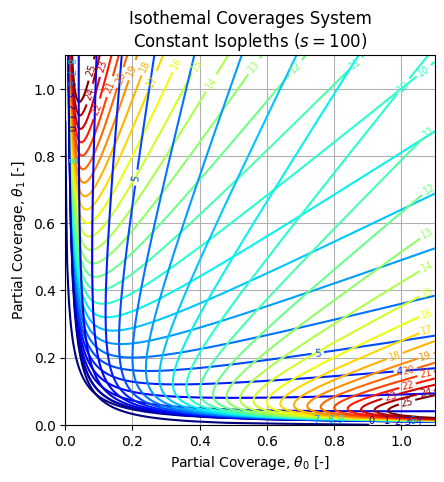

In [23]:
Kinetic.abaque(100)

In [ ]:
Kinetic.abaque(10)